##  Springboard Capstone Project Intracranial Hemorrhage Detection

### Deep Learning Prototype

This notebook is intended for the Deep Learning Prototype for my Springboard Capstone Project.



In [1]:
# import all necessary libraries

import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt


from math import ceil, floor, log
import cv2
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import tensorflow as tf
import keras

import sys

from keras_applications.inception_v3 import InceptionV3

from sklearn.model_selection import ShuffleSplit

test_images_dir = 'test/'
train_images_dir = 'train/'

Using TensorFlow backend.


### Data : Pre-Processing

Resizing images to reduce training speed and improve clarity.

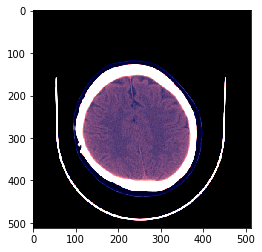

In [3]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img



dicom = pydicom.dcmread(train_images_dir + 'ID_7a0a9661a' + '.dcm')

plt.imshow(bsb_window(dicom), cmap=plt.cm.bone);


### Useful Functions

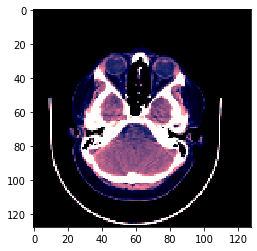

In [4]:
def _read(path, desired_size):
    """Function to read data which will be used in the Data Generator class"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

# Another sanity check 
plt.imshow(
    _read(train_images_dir+'ID_7a0b251ce'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

### Keras Data generators


In [ ]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
                 img_dir=train_images_dir, *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X

### Defining Loss Functions and Metrics

In [ ]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    This function can be used as loss function as model.compile()
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    Keras implementation for numpy.average()
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Using this as the metric in model.compile
    Similar to weighted log loss but with normalized weights
    
    """
    
   
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()



### Deep Learning Model

Model is divided into the following parts: <br> 

* The edited input image is passed to InceptionV3 architecture

* Then the output given by InceptionV3 is average pooled and passes by two dense layes which includes the output layer

In [ ]:

class PredictionCheckpoint(keras.callbacks.Callback):
    
    def __init__(self, test_df, valid_df, 
                 test_images_dir=test_images_dir, 
                 valid_images_dir=train_images_dir, 
                 batch_size=32, input_size=(224, 224, 3)):
        
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
        
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), verbose=2)[:len(self.test_df)])
        



class DLModel:
    
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        
        
        engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)
        
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)

        out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

        self.model = keras.models.Model(inputs=engine.input, outputs=out)

        self.model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[weighted_loss])
    

    def fit_predict(self, train_df, valid_df, test_df):
        
        # callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        
        self.model.fit_generator(
            DataGenerator(
                train_df.index, 
                train_df, 
                self.batch_size, 
                self.input_dims, 
                train_images_dir
            ),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4,
            callbacks=[pred_history, scheduler]
        )
        
        return pred_history
    
    def pred(self,pred_df):
        
        tmp = self.model.predict_generator(DataGenerator(list_IDs = pred_df.index, labels = None, batch_size =  5, input_dims = (256, 256, 3), img_dir =  test_images_dir))
        
        return tmp
        
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        
        self.model.load_weights(path, by_name = True)

### Read all required CSV files

In [ ]:
def read_test(filename="test_df.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_train(filename="train_df.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    dups = df[df.duplicated()].index.tolist()
    
    df = df.drop(index=dups)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

    
test_df = read_test()
train_df = read_train()

In [129]:
train_df.shape

(752803, 6)

In [130]:
test_df.shape

(121232, 6)

In [131]:
test_df.head(3)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000000e27   0.5      0.5              0.5              0.5          0.5   
ID_000009146   0.5      0.5              0.5              0.5          0.5   
ID_00007b8cb   0.5      0.5              0.5              0.5          0.5   

                       
Diagnosis    subdural  
Image                  
ID_000000e27      0.5  
ID_000009146      0.5  
ID_00007b8cb      0.5

In [132]:
# choosing only a section of the data for our prototype
proto_train_df = train_df.iloc[350000:460000]
proto_test_df = test_df.iloc[70000:88000]

### Training Model and Predicting

Using train, validation and test set <br>

#### Strategy

Number of epochs is 5, learning_rate : 0.0005, decay_rate : 0.8. 




In [ ]:
# choosing 90% for training set and 10% for validation set
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(proto_train_df.index)

# building only for the first shuffle
train_idx, valid_idx = next(ss)

# obtain model
model = DLModel(engine=InceptionV3, input_dims=(256, 256, 3), batch_size=32, learning_rate=5e-4,
                    num_epochs=5, decay_rate=0.8, decay_steps=1, weights="imagenet", verbose=1)

# obtain test and validation predictions (history.test_predictions, history.valid_predictions)
history = model.fit_predict(proto_train_df.iloc[train_idx], proto_train_df.iloc[valid_idx], proto_test_df)



In [ ]:
model.model.save('newmod.h5')

In [ ]:
# tmp = model.model.predict_generator(DataGenerator(list_IDs = pred_df.index, labels = None, batch_size =  32, input_dims = (224, 224, 3), img_dir =  test_images_dir), verbose = 2)[:len(pred_df)]

In [ ]:
from keras.models import load_model

In [ ]:
new_model = load_model('newmod.h5', custom_objects={'weighted_loss' : weighted_loss})

In [ ]:
type(new_model)

### Veryfying Model Predictions

In [ ]:
proto_test_df.head()

In [135]:
proto_test_df.iloc[:, :] = np.average(history.test_predictions, axis=0, weights=[0, 1, 2, 4, 6]) # let's do a weighted average for epochs (>1)

proto_test_df = proto_test_df.stack().reset_index()

proto_test_df.insert(loc=0, column='ID', value=proto_test_df['Image'].astype(str) + "_" + proto_test_df['Diagnosis'])

proto_test_df = proto_test_df.drop(["Image", "Diagnosis"], axis=1)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# saving the predictions
proto_test_df.to_csv('preds.csv')

In [136]:
# checking some of our model's best predictions

check = proto_test_df[proto_test_df.Label > 0.80]
check.head(30)

,ID,Label
6,ID_936652b75_any,0.915617
9,ID_936652b75_intraventricular,0.871522
18,ID_9368f250c_any,0.885575
42,ID_936c26faa_any,0.921791
44,ID_936c26faa_intraparenchymal,0.864674
138,ID_93745f15a_any,0.970541
140,ID_93745f15a_intraparenchymal,0.892368
150,ID_937570ae6_any,0.996459
152,ID_937570ae6_intraparenchymal,0.980703
162,ID_9376c6f9e_any,0.961265


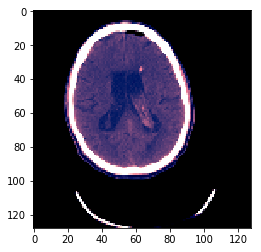

In [141]:
# intraventricular
plt.imshow(
    _read(test_images_dir+'ID_936652b75'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

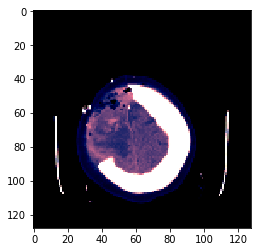

In [138]:
# intraparenchymal
plt.imshow(
    _read(test_images_dir+'ID_936c26faa'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

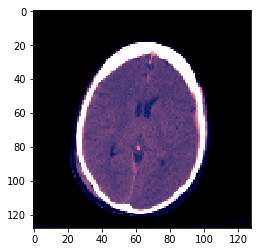

In [139]:
# subdural
plt.imshow(
    _read(test_images_dir+'ID_93bdfe8b1'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

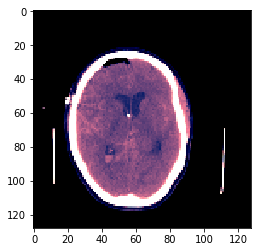

In [140]:
# subarachnoid
plt.imshow(
    _read(test_images_dir+'ID_93b49a67d'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

### Conclusion :

A model to detect intracranial Hemorrhage has been built which was a great learning exprience with the Keras deep learning library. I will continue working to explore other models and try scaling and serving the model to make the most out of it.